# Data Description
The dataset used in this project is the SMS Spam Collection, a public corpus of text messages collected from free and research-friendly sources on the Internet. It consists of 5,574 SMS messages, each labeled as either *spam* (unsolicited or promotional content) or *ham* (legitimate message). This dataset is widely used for training and evaluating models in text classification and natural language processing tasks related to spam detection. 

Source: https://www.kaggle.com/datasets/mariumfaheem666/spam-sms-classification-using-nlp \
Reference: https://scikit-learn.org/stable/

In [4]:
#Importing the data and Suppressing othe warnings.
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.max_columns', None)
SSD = pd.read_csv(r"C:\Users\msour\OneDrive\Documents\IVY\Project DL\Spam_SMS_detection.csv")
SSD.head(5)

,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#Printing the dimension of the Dataset
print(SSD.shape)

(5574, 2)


<Axes: xlabel='Class'>

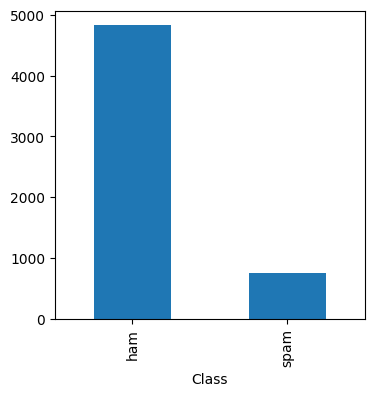

In [2]:
# checking the distribution of the classes
import matplotlib.pyplot as plt
import numpy as np
fig, subplot = plt.subplots(ncols=1,nrows=1,figsize = (4,4))
SSD["Class"].value_counts().plot(kind='bar', ax = subplot)

As there is only 2 unique value in the Target variable, we can convert it to 0 and 1. Spam as 1 and ham as 0.

In [3]:
SSD["Class"] =np.where(SSD["Class"] == "spam", 1,0)

As there is a huge biasness in the data random oversampling is required but, the random oversampling is done after the data is treated properly.

# Text Processing
Cleaning the text to make it a raw text for better analysis.

In [4]:
import re
def text_mine(text):
    new_text = re.sub(r'@[^\s]+',r'',str(text)) #removes any username mentions from the text.
    new_text = re.sub(r'http:\/\/.*[\r\n]*',r'',str(new_text)) #removes any URL/ hyperlinks present in the text.
    new_text = re.sub(r'\d+',r'',str(new_text)) #removes any digit present in the text.
    new_text = re.sub(r'[^\w\s]',r'',str(new_text)) #removes any punctuation and special character in the text.
    new_text = re.sub(r' +',r' ',str(new_text)) #removes multiple spaces to a single spaces
    new_text = re.sub(r"\s+$", r"",str(new_text)) #removes trailing spaces at the end of the text.
    return new_text

In [5]:
SSD["Message"]=SSD["Message"].apply(lambda x: text_mine(x))

Cleaning all the stopping words which doesnot add any additional value to the text, also removing the words which are not in english.

In [6]:
import nltk
from nltk.corpus import words, stopwords
from nltk.tokenize import word_tokenize

# nltk.download('punkt_tab')
# nltk.download('words')
# nltk.download('stopwords')

# Load English words and stop words
english_words = set(words.words())
stop_words = set(stopwords.words())

def clean_words(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Keep words that are in the dictionary and not repetitive gibberish also if the words are not present in the stop word
    meaningful_words = [word for word in tokens if word.lower() in english_words and word.lower() not in stop_words]
    return ' '.join(meaningful_words)

Lemmitization is done to normalize words to their canonical root forms

In [7]:
# Apply the function to the dataset
SSD["Message"]=SSD["Message"].apply(clean_words)

In [8]:
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('omw-1.4')
def lematization(text):
    lemmatizer = WordNetLemmatizer() # Create object for lemmatizer to also specify the part of speech
    words = word_tokenize(text)
    text_with_lemmatized = list(set([lemmatizer.lemmatize(word) for word in words]))
    # set is taken to get unique words for each text
    return " ".join(text_with_lemmatized)

In [9]:
SSD["Message"]=SSD["Message"].apply(lematization)

# Data Visualisation

In [10]:
# group the dataset into spam and ham
groups = SSD.groupby('Class')
spam = groups.get_group(1)
ham = groups.get_group(0)

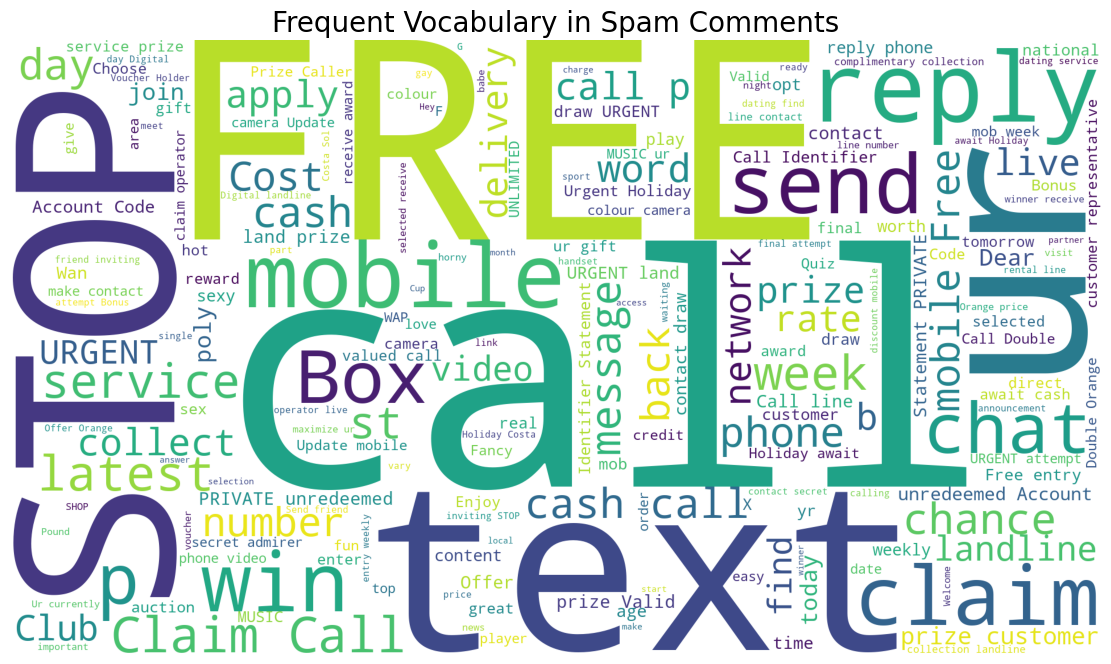

In [11]:
# visualize the common vocabulary in spam emails
from wordcloud import WordCloud
import matplotlib.pyplot as plt
combined_title = ' '.join(spam['Message'])

# creating a word cloud using the combined text
wordcloud_title = WordCloud(width = 1920, height = 1080, background_color ='white', min_font_size = 10).generate(combined_title)

# plot the WordCloud image
plt.figure(figsize=(15,7))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('Frequent Vocabulary in Spam Comments', fontsize=20)
plt.tight_layout(pad=2)
plt.show()

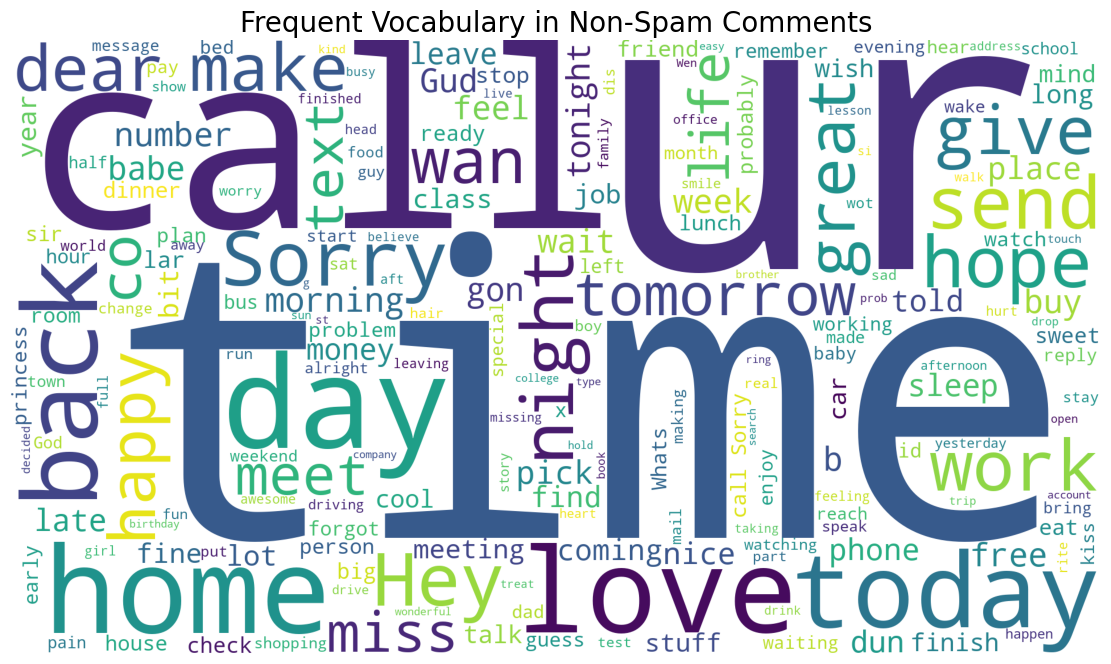

In [12]:
# visualize the common vocabulary in non spam emails
from wordcloud import WordCloud
import matplotlib.pyplot as plt
combined_title = ' '.join(ham['Message'])

# create a word cloud using the combined text
wordcloud_title = WordCloud(width = 1920, height = 1080, background_color ='white', min_font_size = 10).generate(combined_title)

# plot the WordCloud image
plt.figure(figsize=(15,7))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('Frequent Vocabulary in Non-Spam Comments', fontsize=20)
plt.tight_layout(pad=2)
plt.show()

# TF-IDF Vectorization: converting text data to numeric

In [13]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from scipy.sparse import vstack

# Define a function to vectorize a chunk of the corpus
def vectorize_chunk(chunk, vectorizer):
    return vectorizer.transform(chunk)

# Creating the vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
# Fitting on the full corpus
vectorizer.fit(SSD["Message"])

# Splitting the corpus into chunks
num_chunks = 4  # Number of parallel processes
chunks = np.array_split(SSD["Message"], num_chunks)

# Using parallel processing to transform each chunk
X_chunks = Parallel(n_jobs=num_chunks)(delayed(vectorize_chunk)(chunk, vectorizer) for chunk in chunks)

# Combining sparse matrices
X_combined = vstack(X_chunks)

# Creating a sparse DataFrame
DML = pd.DataFrame.sparse.from_spmatrix(X_combined, columns=vectorizer.get_feature_names_out())
DML['Class'] = SSD['Class'].values

# Dimension Reduction
using PCA to reduce the numnber of columns

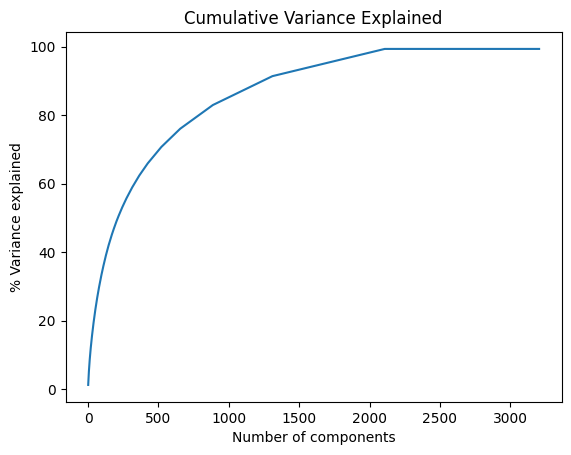

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Subsetting data for X and y
TargetVariable = DML.columns[-1]
X = X_combined.toarray() 
Y = DML[TargetVariable].values

# Creating maximum components equal to the total number of columns to analyze all of them
pca = PCA(n_components=X.shape[1])
pca_fit=pca.fit(X) # fitting the data
reduced_X = pca_fit.transform(X) # calculating the principal components

var_explained= pca.explained_variance_ratio_ # The Amount of variance explained by each principle componnent
var_explained_cumulative=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

# Plot the variance explained
plt.plot(range(1, len(var_explained_cumulative) + 1), var_explained_cumulative)
plt.xlabel('Number of components')
plt.ylabel('% Variance explained')
plt.title('Cumulative Variance Explained')
plt.show()

The Variance gets saturated at aproximately 2100 principal components. Hence, for further analysis number of components is chosen to be 2100.

In [15]:
# Creating 2100 Principal components based on the above curve
NumComponents=2100
pca = PCA(n_components=NumComponents)
# fitting the data
pca_fit=pca.fit(X)
# calculating the principal components
reduced_X = pca_fit.transform(X)
X = reduced_X
# Generating Predictor names
Predictors = []
for i in range(1,NumComponents+1):
    Predictors.append("PC"+str(i))

# Random Over Sampling
Random Oversampling is done as the data is biased.

<Axes: >

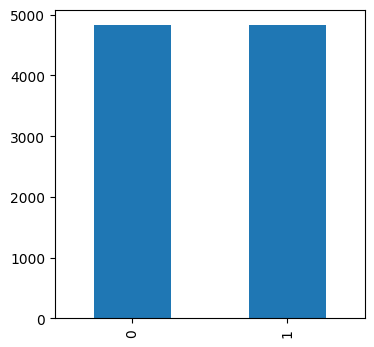

In [16]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler() # initiating random over sampling.
X,Y = ros.fit_resample(X,Y) # resampling X and Y so that equal number of records is present for both the classes.
fig, subplot = plt.subplots(ncols=1,nrows=1,figsize = (4,4))
Y_series = pd.Series(Y)
Y_series.value_counts().plot(kind='bar', ax = subplot)

# Data Processing

In [17]:
# Standardization of the Data and splitting the data into test train split.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
PredictorScaler=MinMaxScaler()
PredictorScalerFit=PredictorScaler.fit(X)
X=PredictorScalerFit.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(7723, 2100)
(7723,)
(1931, 2100)
(1931,)


# Model Selection

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

models = {
    'LogisticRegression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10],
                        'penalty': ['l1', 'l2'], 'fit_intercept': [True, False]}),
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 
                    'decision_function_shape': ['ovo', 'ovr']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 10], 'weights': ['uniform', 'distance'], 'p': [1, 2]}),
    'MultinomialNB': (MultinomialNB(), { 'alpha': [0.1, 0.5, 1.0, 10.0], 'fit_prior': [True, False]}),
    'GaussianNB': (GaussianNB(), {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]})
}

In [19]:
def best_classification_model_evaluation(model, X_train, X_test, Y_train, Y_test):
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    # Metrics
    Accuracy_Train =  accuracy_score(Y_train, Y_pred_train)
    Accuracy_Test = accuracy_score(Y_test, Y_pred_test)
    F1_Weighted_Train = f1_score(Y_train, Y_pred_train, average='weighted')
    F1_Weighted_Test = f1_score(Y_test, Y_pred_test, average='weighted')
    return{
        'Accuracy Train': Accuracy_Train,
        'Accuracy Test': Accuracy_Test,
        'F1 Weighted Train': F1_Weighted_Train,
        'F1 Weighted Test': F1_Weighted_Test}

In [20]:
results = []  #blank list which contains the model name, parameters and also scores
for name, (model, param_grid) in models.items():
    grid = RandomizedSearchCV(model, param_grid, n_iter=5, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
    grid.fit(X_train, Y_train)
    metrics = best_classification_model_evaluation(grid.best_estimator_, X_train, X_test, Y_train, Y_test)
    row = { 'Model': name, 'Best Params': grid.best_params_, **metrics}
    results.append(row)
results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy Test", ascending=False)

,Model,Best Params,Accuracy Train,Accuracy Test,F1 Weighted Train,F1 Weighted Test
1,SVC,"{'kernel': 'rbf', 'gamma': 'scale', 'decision_...",0.988864,0.984982,0.988865,0.984981
2,KNN,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.991713,0.983428,0.991713,0.983429
0,LogisticRegression,"{'penalty': 'l2', 'fit_intercept': True, 'C': 1}",0.986922,0.982910,0.986922,0.982910
3,MultinomialNB,"{'fit_prior': True, 'alpha': 0.1}",0.900945,0.889694,0.900841,0.889531
4,GaussianNB,{'var_smoothing': 1e-06},0.599249,0.572242,0.546465,0.516104


In [21]:
# Printing the Best parameters of the model with the maximum test Accuracy. 
results_df.iloc[1,1]

{'kernel': 'rbf', 'gamma': 'scale', 'decision_function_shape': 'ovo', 'C': 10}

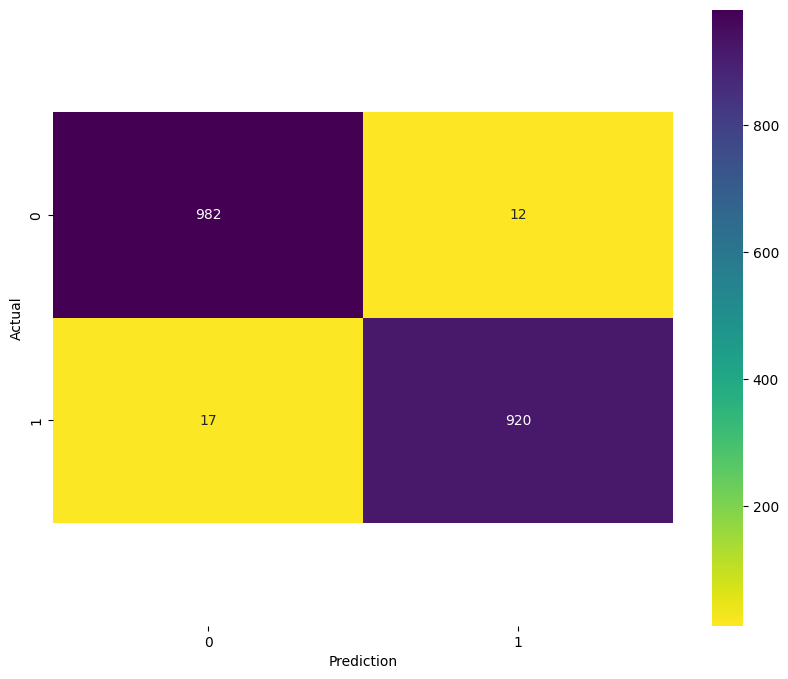

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       994
           1       0.99      0.98      0.98       937

    accuracy                           0.98      1931
   macro avg       0.99      0.98      0.98      1931
weighted avg       0.98      0.98      0.98      1931



In [24]:
#predicting with the final model
import seaborn as sns
final_model = SVC(kernel =  'rbf', gamma = 'scale', decision_function_shape =  'ovo', C = 10)
final_model.fit(X_train, Y_train)
Y_pred_test = final_model.predict(X_test)

# Checking Confusion Metrix
cnf_matrix = confusion_matrix(Y_test, Y_pred_test)
plt.figure(figsize=(10,8))
ax = sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'viridis_r', fmt = 'd')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(Y_test, Y_pred_test))

In [63]:
#printing the sample data with prediction.
prediction_dataframe = pd.DataFrame({"Actual": Y_test, "Predicted": Y_pred_test})
prediction_dataframe.tail(10)

,Actual,Predicted
1921,1,1
1922,0,0
1923,0,0
1924,1,1
1925,1,1
1926,1,1
1927,1,1
1928,1,1
1929,1,1
1930,1,1


# Making predictions for New Cases
This final model is deployed in production to classify the new incoming tickets. To do this, we write a function which can generate predictions either one at a time OR for multiple cases input as a data frame.

In [40]:
# Defining a function which converts words into numeric vectors for prediction
def Prediction_function(inpText):
    # Using the same vectorizer converting the text to numeric vector
    print("Vectorizer : ",vectorizer)
    X=vectorizer.transform(inpText)

    # calculating the principal components
    print("PCA : ",pca_fit)
    reduced_X = pca_fit.transform(X.toarray())

    # standardization/normalization is done on training
    print("Scalar Fit : ",PredictorScalerFit)
    X=PredictorScalerFit.transform(reduced_X)

    # Generating the prediction using Naive Bayes model and returning
    print("Model Used : ",final_model)
    Prediction=final_model.predict(X)
    Result=pd.DataFrame(data=inpText, columns=['Text'])
    Result['Prediction']= "spam" if Prediction[0]==1 else "ham"
    print(Prediction)
    return(Result)

In [42]:
# Calling the function
NewText=[Text2]
PredictionResults=Prediction_function(inpText=NewText)
PredictionResults

Vectorizer :  TfidfVectorizer(stop_words='english')
PCA :  PCA(n_components=2100)
Scalar Fit :  MinMaxScaler()
Model Used :  SVC(C=10, decision_function_shape='ovo')
[0]


,Text,Prediction
0,Ok lar... Joking wif u oni...,ham


In [37]:
#Sample text
Text1 = "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
Text2 = "Ok lar... Joking wif u oni..."
Text3 = "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
Text4 = "U dun say so early hor... U c already then say..."
Text5 = "Nah I don't think he goes to usf, he lives around here though"
Text6 = "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"
Text7 = "Even my brother is not like to speak with me. They treat me like aids patent."
Text8 = "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"
Text9 = "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."